In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import emcee, tqdm, corner

from pylab import cm

In [3]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [4]:
import emcee, corner

In [5]:
%config Completer.use_jedi = False

## Likelihood model

In [6]:
def loglike(l, Cl, a, gamma):
    return np.sum(gamma * np.log(a+l) - 0.5*(a+l)**(2*gamma) * (1/(a+l)**gamma - Cl)**2)

def loglike(l, Cl, params, grad=False):
    if not grad:
        x = (2*l+1)*Cl / model(l, params)
        lnl = np.sum( (l-0.5)*np.log(x)-x/2 )
        if np.isnan(lnl): print(params)
        return lnl
    else: 
        mod_vals, mod_grad = model(l, params, grad=grad)
        x = (2*l+1)*Cl / mod_vals
        x_prime = -(2*l+1)*Cl / mod_vals**2 * mod_grad
        lnl_val = np.sum( (l-0.5)*np.log(x)-x/2 )
        lnl_grad = np.sum( x_prime * ((l-0.5)/x - 1/2) , axis=1)
        
        return lnl_val, lnl_grad

def model(l, params):
    A = np.exp(params[0])
    gamma=params[1]
    return A*(l+1)**gamma

def model(l, params, grad=False):
    A = np.exp(params[0])
    a = np.exp(params[1])
    gamma=params[2]
    mod_vals = A*(a*(l+1)/(a+l))**gamma
    if not grad: return mod_vals
    mod_grad = np.array([A*(a*(l+1)/(a+l))**gamma,
                         A*(a*(l+1)/(a+l))**gamma * (gamma*l)/(a*(a+l)) * a,
                         A*(a*(l+1)/(a+l))**gamma * np.log(a*(l+1)/(a+l))])
    return mod_vals, mod_grad

def model(l, params, grad=False):
    A = np.exp(params[0])
    gamma=params[1]
    mod_vals = A*(l+1)**gamma
    if not grad: return mod_vals
    mod_grad = np.array([A*(l+1)**gamma,
                         A*(l+1)**gamma * np.log(l+1)])
    return mod_vals, mod_grad

In [14]:
logit = lambda p: np.log(p/(1-p))

In [15]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

## Astrometry

In [ ]:
gaiaedr3_astrometry_kncounts_Gres1hpx5.h

In [ ]:
M = 17; C=1; nside=512
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_astrometry_kncounts_Gres1hpx5.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=(3))
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=(3))
    M_bins = hf['magbins'][...]
box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])
magbins = np.linspace(M_bins[0], M_bins[-1], M+1)

In [18]:
M = 17; C=1; nside=64
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=(3))
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=(3))
    M_bins = hf['magbins'][...]
box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])
magbins = np.linspace(M_bins[0], M_bins[-1], M+1)

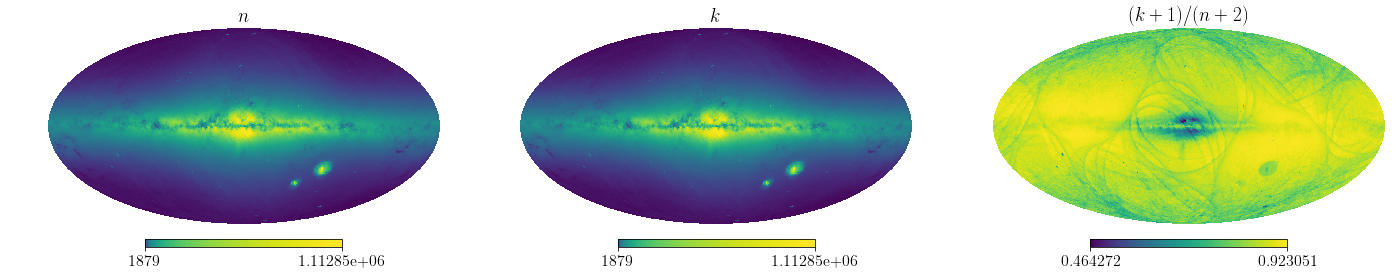

In [10]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

minmax = np.min(box['n']), np.max(box['n'])

plt.sca(axes[0])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',# min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$n$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[1])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',#min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$k$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[2])
hp.mollview((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2), nest=True, notext=True, norm='log',
            coord=['C','G'], title=r'$(k+1)/(n+2)$', cmap='viridis', hold=True, cbar=True, xsize=2000)

In [50]:
lmax=600; lmax_fit=50
lvals = np.arange(lmax+1)
    
x = logit((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2))
spectrum_full = hp.anafast(x, lmax=lmax)

In [51]:
nll = lambda x: -loglike(lvals[:lmax_fit], spectrum_full[:lmax_fit], x)
result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
result

   direc: array([[-0.08273929,  0.02860586],
       [-0.03326192,  0.01397252]])
     fun: -2957.901294623757
 message: 'Optimization terminated successfully.'
    nfev: 772
     nit: 27
  status: 0
 success: True
       x: array([13.57780177, -2.82640533])

In [52]:
def nll(x):
    lnl, lnl_grad = loglike(lvals[:lmax_fit], spectrum_full[:lmax_fit], x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -2959.3157161554623
     jac: array([-0.02258905, -0.05620102])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 32
  status: 0
 success: True
       x: array([13.90291688, -2.91489049])

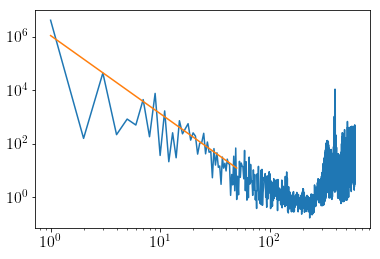

In [54]:
plt.plot(lvals+1, spectrum_full)
plt.plot(lvals[:lmax_fit]+1, model(lvals[:lmax_fit], result['x']))
plt.yscale('log'); plt.xscale('log')

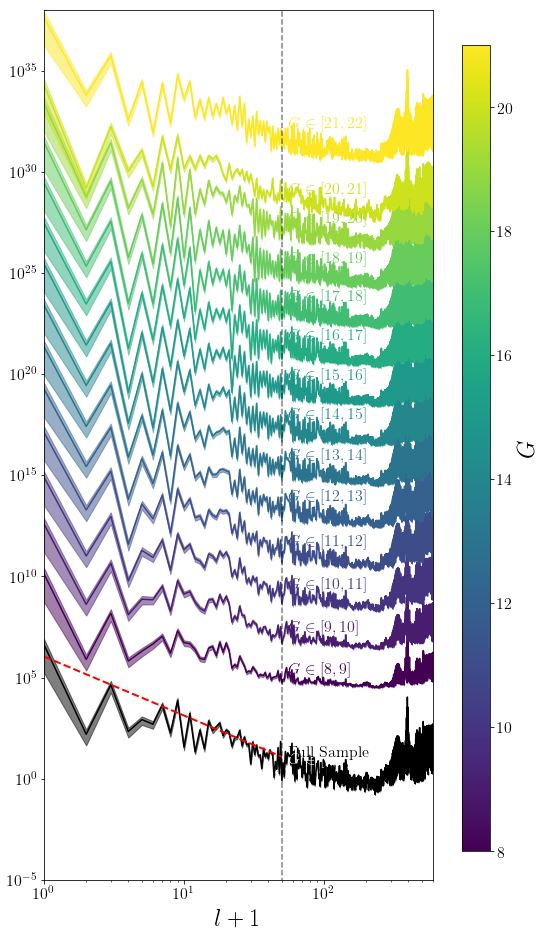

In [58]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = -1

for i, mag in tqdm.tqdm_notebook(enumerate(magbins[:-1]), total=len(magbins[:-1])):    
    n_sample = box['n'][i,0]
    k_sample = box['k'][i,0]
    x = logit((k_sample+1)/(n_sample+2))
    spectrum = hp.anafast(x, lmax=lmax)

    plt.plot(lvals+1, spectrum*10**(2*float(offset+i)), color=cmap((mag-mmin)/(mmax-mmin)))
    plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(offset+i)), 
                    spectrum*var_upper*10**(2*float(offset+i)), color=cmap((mag-mmin)/(mmax-mmin)),
                    alpha=0.5)

    plt.text(lmax_fit*1.1, spectrum[lmax_fit]*10**(2*float(offset+i+0.15)), r'$G\in[%.0f,%.0f]$'%(magbins[i],magbins[i+1]),
             ha='left', color=cmap((mag-mmin)/(mmax-mmin)))

x = logit((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2))
spectrum = hp.anafast(x, lmax=lmax)

plt.plot(lvals+1, spectrum, color='k')
plt.fill_between(lvals+1, spectrum*var_lower, spectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
plt.text(lmax_fit*1.1, spectrum[lmax_fit]*10**(2*0.15), r'Full Sample', ha='left', color='k')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.plot([lmax_fit,lmax_fit],[1e-20,1e40],'--k', alpha=0.5)
plt.ylim(1e-5, 1e38)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

#plt.savefig('figs/powerspectrum_betamean_fit-pl_ast_nside%d.png' % nside, bbox_inches='tight')

## RUWE

In [18]:
M = 17; C=1; nside=64
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_ruwe1p4_arr_hpx128.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=(3))
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=(3))
    M_bins = hf['magbins'][...]
box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])
magbins = np.linspace(M_bins[0], M_bins[-1], M+1)

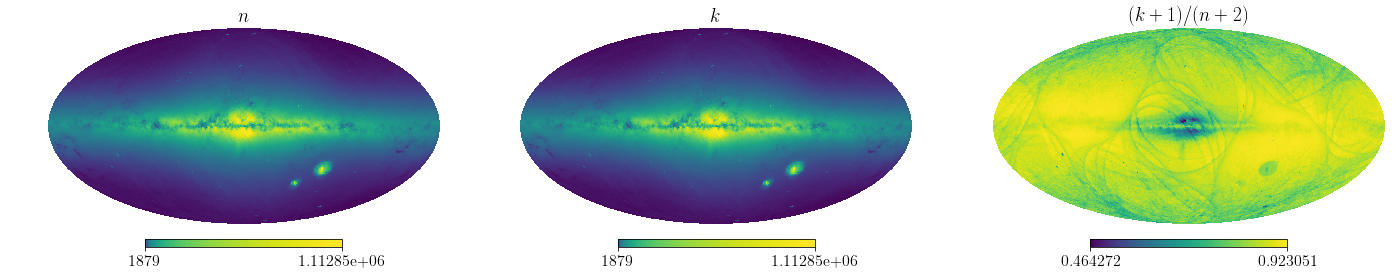

In [10]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

minmax = np.min(box['n']), np.max(box['n'])

plt.sca(axes[0])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',# min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$n$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[1])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',#min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$k$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[2])
hp.mollview((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2), nest=True, notext=True, norm='log',
            coord=['C','G'], title=r'$(k+1)/(n+2)$', cmap='viridis', hold=True, cbar=True, xsize=2000)

In [50]:
lmax=600; lmax_fit=50
lvals = np.arange(lmax+1)
    
x = logit((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2))
spectrum_full = hp.anafast(x, lmax=lmax)

In [51]:
nll = lambda x: -loglike(lvals[:lmax_fit], spectrum_full[:lmax_fit], x)
result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
result

   direc: array([[-0.08273929,  0.02860586],
       [-0.03326192,  0.01397252]])
     fun: -2957.901294623757
 message: 'Optimization terminated successfully.'
    nfev: 772
     nit: 27
  status: 0
 success: True
       x: array([13.57780177, -2.82640533])

In [52]:
def nll(x):
    lnl, lnl_grad = loglike(lvals[:lmax_fit], spectrum_full[:lmax_fit], x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -2959.3157161554623
     jac: array([-0.02258905, -0.05620102])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 32
  status: 0
 success: True
       x: array([13.90291688, -2.91489049])

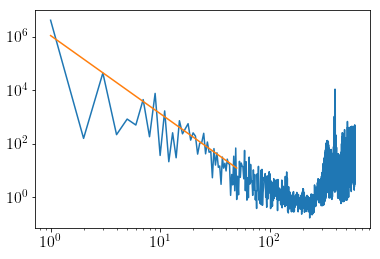

In [54]:
plt.plot(lvals+1, spectrum_full)
plt.plot(lvals[:lmax_fit]+1, model(lvals[:lmax_fit], result['x']))
plt.yscale('log'); plt.xscale('log')

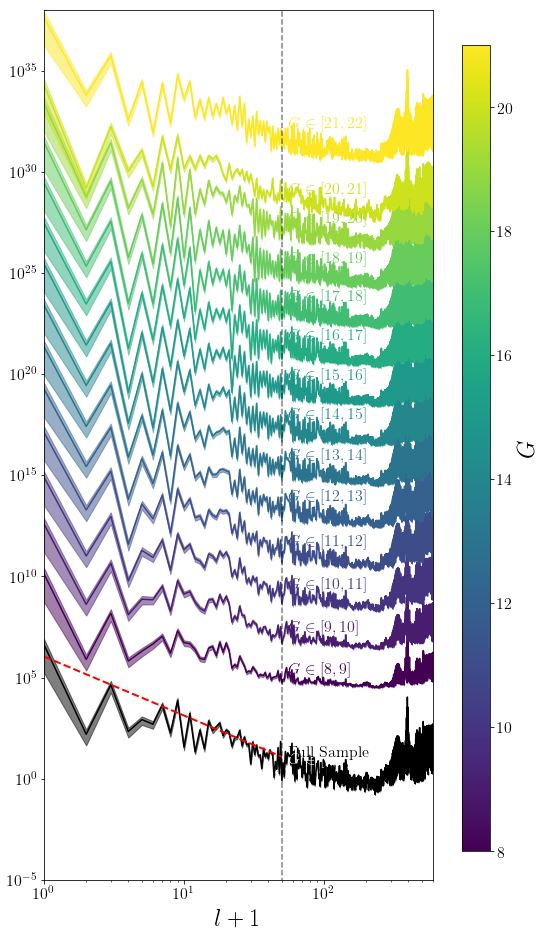

In [58]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = -1

for i, mag in tqdm.tqdm_notebook(enumerate(magbins[:-1]), total=len(magbins[:-1])):    
    n_sample = box['n'][i,0]
    k_sample = box['k'][i,0]
    x = logit((k_sample+1)/(n_sample+2))
    spectrum = hp.anafast(x, lmax=lmax)

    plt.plot(lvals+1, spectrum*10**(2*float(offset+i)), color=cmap((mag-mmin)/(mmax-mmin)))
    plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(offset+i)), 
                    spectrum*var_upper*10**(2*float(offset+i)), color=cmap((mag-mmin)/(mmax-mmin)),
                    alpha=0.5)

    plt.text(lmax_fit*1.1, spectrum[lmax_fit]*10**(2*float(offset+i+0.15)), r'$G\in[%.0f,%.0f]$'%(magbins[i],magbins[i+1]),
             ha='left', color=cmap((mag-mmin)/(mmax-mmin)))

x = logit((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2))
spectrum = hp.anafast(x, lmax=lmax)

plt.plot(lvals+1, spectrum, color='k')
plt.fill_between(lvals+1, spectrum*var_lower, spectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
plt.text(lmax_fit*1.1, spectrum[lmax_fit]*10**(2*0.15), r'Full Sample', ha='left', color='k')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.plot([lmax_fit,lmax_fit],[1e-20,1e40],'--k', alpha=0.5)
plt.ylim(1e-5, 1e38)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

#plt.savefig('figs/powerspectrum_betamean_fit-pl_ast_nside%d.png' % nside, bbox_inches='tight')

In [88]:
N=int(1e6)
sigma_X = 10
X = np.random.normal(0, sigma_X, N)
Y = np.random.normal(0, 2, N)

In [89]:
Z = X**2

In [90]:
2*sigma_X**4

20000

In [91]:
np.std(Z)**2

20007.697995193554

In [67]:
Z = X**2 + 10*Y

In [70]:
12*5**4 + 10 * 2**2

7540